In [8]:
import specpy
import numpy as np

a = specpy.get_application()

In [14]:
meas = a.active_measurement()
cfg = meas.active_configuration()
meas.parameters('')

{'Measurement': {'LoopMeasurement': 0,
  'MeasTime': 'Friday, July 07 2023  10:47:12',
  'axes': {'bidirectional_scan': True,
   'concatenate': False,
   'minflux_scan': False,
   'num_synced': 0,
   'permanent_add': False,
   'resume_position': 0,
   'rewind_axis': 0,
   'scan_axes': ['ExpControl X', 'ExpControl Y', 'None', 'None'],
   'split_axis': 0,
   'split_num_steps': 1,
   'split_type': 0,
   'update_axis': 4,
   'update_step': 1},
  'propset_id': 7,
  'propset_label': 'ov narrow'},
 '_control': {'parent': -1,
  'protected': False,
  'stop': False,
  'temporary': False},
 'prop_version': 2,
 'spec_version': '16.3.15635-m2205'}

In [32]:
meas = a.active_measurement()
img = meas.stack(5).data()
print(np.shape(img))

(1, 1, 120, 118)


In [1]:
import specpy
dir(specpy)
help(specpy)

Help on package specpy:

NAME
    specpy

PACKAGE CONTENTS
    _specpy
    specpy
    version

CLASSES
    builtins.SwigPyObject(builtins.object)
        DeviceStatus
        Error
        File
        Folder
        HardwareStatus
        HookRegistrationFlags
        IsConvertible
            Future
            Object
                Application
                Configuration
                Device
                Measurement
                Stack
            Promise
        Log
        MeasurementFlags
        MeasurementGuiLock
        MeasurementGuiLockFlags
        MeasurementResult
        MeasurementSignal
        MeasurementStartFlags
        Minflux
        Query
        Value
        ValueMode
        ValueNotification
        ValueNotifyReason
        ValueTree
    
    class Application(Object)
     |  Remote::Application
     |  
     |  Method resolution order:
     |      Application
     |      Object
     |      IsConvertible
     |      builtins.SwigPyObject
     |   

In [17]:
import specpy
import numpy as np
import matplotlib.pyplot as plt

ims = specpy.get_application()

stack 0: shape (1, 1, 800, 800)
stack 1: shape (1, 1, 1000, 1000)
stack 2: shape (1, 1, 800, 800)
stack 3: shape (1, 1, 1000, 1000)
stack 4: shape (1, 1, 1000, 1000)
stack 5: shape (1, 1, 93, 125)
stack 6: shape (1, 1, 93, 125)
stack 7: shape (1, 1, 25, 25)
stack 8: shape (1, 1, 25, 25)
(800, 800)


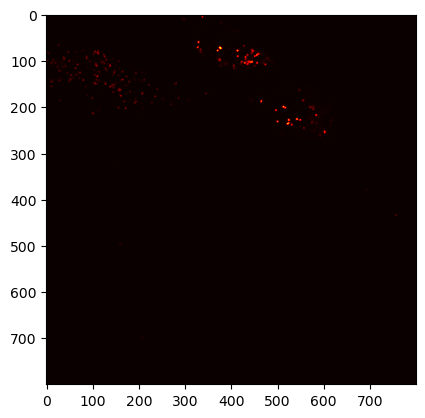

In [31]:
meas = ims.active_measurement()
for i in range(9):
    img = meas.stack(i).data()
    print(f'stack {i}: shape {np.shape(img)}')

img = np.squeeze(meas.stack(0).data())
print(np.shape(img))
plt.imshow(img, cmap='hot')

In [41]:
import numpy as np
from scipy import ndimage as ndi
import cv2
from scipy.spatial import cKDTree, distance

def peak_detection(img, prev_frames=None, binary_mask=None, testmode=False, exinfo=None,
                        min_dist=30, thresh_abs=20, num_peaks=10, smoothing_radius=2, 
                        ensure_spacing=1, border_limit=15, init_smooth=1):
    """
    Common parameters:
    img - current image,
    prev_frames - previous image(s)
    binary_mask - binary mask of the region to consider
    testmode - to return preprocessed image or not
    exinfo - pandas dataframe of the detected vesicles and their track ids from the previous frames

    Pipeline specific parameters:
    min_dist - minimum distance in pixels between two peaks
    thresh_abs - low intensity threshold in img_ana of the peaks to consider
    num_peaks - number of peaks to track
    smoothing_radius - diameter of Gaussian smoothing of img_ana, in pixels
    ensure_spacing - to ensure spacing between detected peaks or not (bool 0/1)
    border_limit - how much of the border to remove peaks from in pixels
    init_smooth - if to perform an initial smoothing of the raw image or not (bool 0/1)
    """

    if binary_mask is None or np.shape(binary_mask) != np.shape(img):
        binary_mask = np.ones(np.shape(img)).astype('uint16')

    img = np.array(img).astype('float32')
    if init_smooth==1:
        img = ndi.filters.gaussian_filter(img, smoothing_radius)

    # multiply with binary mask
    img_ana = img * np.array(binary_mask)

    # Peak_local_max as a combo of opencv and numpy
    size = int(2 * min_dist + 1)
    img_ana = np.clip(img_ana, a_min=0, a_max=None)
    img_ana = img_ana.astype('float32')
    # get filter structuring element
    footprint = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=[size,size])
    # maximum filter (dilation + equal)
    image_max = cv2.dilate(img_ana, kernel=footprint)
    mask = np.equal(img_ana, np.array(image_max))
    mask &= np.greater(img_ana, thresh_abs)
    
    # get coordinates of peaks
    coordinates = np.nonzero(mask)
    intensities = img_ana[coordinates]
    # highest peak first
    idx_maxsort = np.argsort(-intensities)
    coordinates = tuple(arr for arr in coordinates)
    coordinates = np.transpose(coordinates)[idx_maxsort]
    
    if ensure_spacing==1:
        output = coordinates
        if len(coordinates):
            # Use KDtree to find the peaks that are too close to each other
            tree = cKDTree(coordinates, balanced_tree=False, compact_nodes=False, leafsize=50)
            indices = tree.query_ball_point(coordinates, workers=1, r=min_dist, p=np.inf, return_sorted=False)
            rejected_peaks_indices = set()
            for idx, candidates in enumerate(indices):
                if idx not in rejected_peaks_indices:
                    # keep current point and the points at exactly spacing from it
                    candidates.remove(idx)
                    dist = distance.cdist(
                        [coordinates[idx]],
                        coordinates[candidates],
                        distance.minkowski,
                        p=np.inf,
                    ).reshape(-1)
                    candidates = [
                        c for c, d in zip(candidates, dist) if d < min_dist
                    ]
                    # candidates.remove(keep)
                    rejected_peaks_indices.update(candidates)
            # Remove the peaks that are too close to each other
            output = np.delete(coordinates, tuple(rejected_peaks_indices), axis=0)
        coordinates = output

    # remove everything on the border (takes ~2-3ms if there are a lot of detected coordinates, but usually this is not the case)
    imsize = np.shape(img)[0]
    idxremove = []
    for idx, coordpair in enumerate(coordinates):
        if coordpair[0] < border_limit or coordpair[0] > imsize - border_limit or coordpair[1] < border_limit or coordpair[1] > imsize - border_limit:
            idxremove.append(idx)
    coordinates = np.delete(coordinates,idxremove,axis=0)

    # remove everyhting down to a certain length
    if len(coordinates) > num_peaks:
        coordinates = coordinates[:int(num_peaks),:]

    if testmode:
        return coordinates, exinfo, img_ana.get()
    else:
        return coordinates, exinfo


C:\Users\alvelidjonatan\AppData\Local\Temp\ipykernel_21436\3094226684.py:32: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  img = ndi.filters.gaussian_filter(img, smoothing_radius)


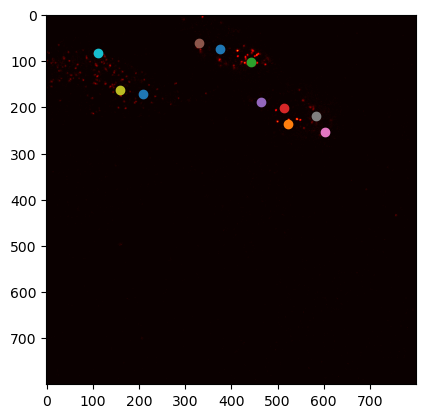

In [72]:
coords = peak_detection(img, thresh_abs=5, num_peaks=30)

plt.imshow(img, cmap='hot')
for i in range(len(coords[0])):
    plt.scatter(coords[0][i][1], coords[0][i][0])
    pass